In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import snakeviz
%load_ext snakeviz

from utils.system import CarSystem, TimeVaryingLinearStateSystem

# system equations

we consider the case 

$x^{t+1} = A_{\theta^t} x^t + B_{\theta^t} u^t + \zeta_t^x$

$\theta^{t+1} = \theta^t + \zeta^t_\theta$

$y^{t+1} = C_{\theta^t} x^t  + \zeta^t_y$

for a car moving in 1-d we have

$\theta = [\theta_1, \theta_2, \theta_3, \theta_4] = $ [mass, airfrictioncoeff, slope, motorresponse,]

$x = [x_1, x_2, x_3] = $ [velocity, position, 1]

$u = [u_1] $ = [motorvoltage]

$A_{\theta} =   \left|\begin{matrix} 
                -\theta_2/\theta_1, & 0, & -\theta_3/\theta_1, \\
                1, & 0, & 0, \\
                0, & 0, & 0, \\
                \end{matrix}\right|$
            
$B_{\theta} =   \left|\begin{matrix} 
                \theta_4/\theta_1, \\
                0, \\
                0, \\
                \end{matrix}\right|$

$C_{\theta} =   \left|\begin{matrix} 0, 1, 0
                \end{matrix}\right|$

In [2]:
class SystemLogger():
    def __init__(self):
        self.statelog = []
        self.paramlog = []

    def log(self, system):
        self.statelog.append(system.state)
        self.paramlog.append(system.theta)

    @property
    def state_trajectories(self):
        return np.hstack(self.statelog)
    
    @property
    def parameters_trajectories(self):
        return np.hstack(self.paramlog)

In [ ]:
from scipy.optimize import minimize
from functools import partial
from scipy.stats import multivariate_normal

def update_distribution(prior_mu, prior_sigma, measured_x, measure_sigma):
    prior_precision = np.linalg.inv(prior_sigma)
    measure_precision = np.linalg.inv(measure_sigma)

    posterior_precision = prior_precision + measure_precision
    posterior_sigma = np.linalg.inv(posterior_precision)
    posterior_mu = np.linalg.inv(posterior_precision) @ (prior_precision@prior_mu + measure_precision@measured_x)
    return posterior_mu, posterior_sigma

def transform_distribution(prior_mu, prior_sigma, A, bias=0):
    transformed_mu = A@prior_mu 
    transformed_sigma = A@prior_sigma@A.T + bias
    return transformed_mu, transformed_sigma

def negative_loglikelihood_theta(theta, mu_x, sigma_x, measured_x, sigma_measure, A):
    mu_x, sigma_x = transform_distribution(mu_x, sigma_x, A(theta.item()))
    loglikelihood = multivariate_normal(mean=mu_x, cov=sigma_x+sigma_measure).logpdf(measured_x)
    return -loglikelihood

def update_theta(thetaest, mu_x, sigma_x, measured_x, sigma_measure, A):
    neg_ll = partial(negative_loglikelihood_theta, mu_x=mu_x, sigma_x=sigma_x, measured_x=measured_x, sigma_measure=sigma_measure, A=A)
    res = minimize(neg_ll, x0=thetaest, method='BFGS', options={'disp': False})
    return res["x"].item()


class SystemStateEstimator(TimeVaryingLinearStateSystem):
    def __init__(self, system, state_mu, state_sigma):
        self.internal_system = system
        self.estimated_state_mu, self.estimated_state_sigma = state_mu, state_sigma


    def step(self, control, dt):
        self.internal_system.step(control, dt)






In [3]:
def plotdistr(mu, sigma, xtrue, xobs):
    px = np.random.multivariate_normal(mu, sigma, size=10000).T
    plt.hist2d(px[0],px[1], bins=100, range=([-10,10],[-10,10]), cmap="Blues")
    plt.axis([-10,10,-10,10])
    plt.plot(xtrue[0],xtrue[1], "rx")
    plt.plot(xobs[0],xobs[1], "bx")

def update_distribution(prior_mu, prior_sigma, measured_x, measure_sigma):
    prior_precision = np.linalg.inv(prior_sigma)
    measure_precision = np.linalg.inv(measure_sigma)

    posterior_precision = prior_precision + measure_precision
    posterior_sigma = np.linalg.inv(posterior_precision)
    posterior_mu = np.linalg.inv(posterior_precision) @ (prior_precision@prior_mu + measure_precision@measured_x)
    return posterior_mu, posterior_sigma

def transform_distribution(prior_mu, prior_sigma, A, bias=0):
    transformed_mu = A@prior_mu 
    transformed_sigma = A@prior_sigma@A.T + bias
    return transformed_mu, transformed_sigma

def observe(x, sigma_noise):
    return np.random.multivariate_normal(x, sigma_noise)

In [7]:
from scipy.optimize import minimize
from functools import partial
from scipy.stats import multivariate_normal

def negative_loglikelihood_theta(theta, mu_x, sigma_x, measured_x, sigma_measure, A):
    mu_x, sigma_x = transform_distribution(mu_x, sigma_x, A(theta.item()))
    loglikelihood = multivariate_normal(mean=mu_x, cov=sigma_x+sigma_measure).logpdf(measured_x)
    return -loglikelihood

def update_theta(thetaest, mu_x, sigma_x, measured_x, sigma_measure, A):
    neg_ll = partial(negative_loglikelihood_theta, mu_x=mu_x, sigma_x=sigma_x, measured_x=measured_x, sigma_measure=sigma_measure, A=A)
    res = minimize(neg_ll, x0=thetaest, method='BFGS', options={'disp': False})
    return res["x"].item()

C:\Users\dsart\AppData\Local\Temp\ipykernel_19016\3975751610.py:12: OptimizeWarning: Unknown solver options: xatol
  res = minimize(prova, x0=thetaest, method='BFGS', options={'xatol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 2.905498
         Iterations: 7
         Function evaluations: 16
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 3.247348
         Iterations: 5
         Function evaluations: 14
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 4.541215
         Iterations: 7
         Function evaluations: 18
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 3.007276
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2.943647
         Iterations: 6
         Function evaluations: 16
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 4.220091
         Iterations: 5
         Function evaluations: 14
         Grad

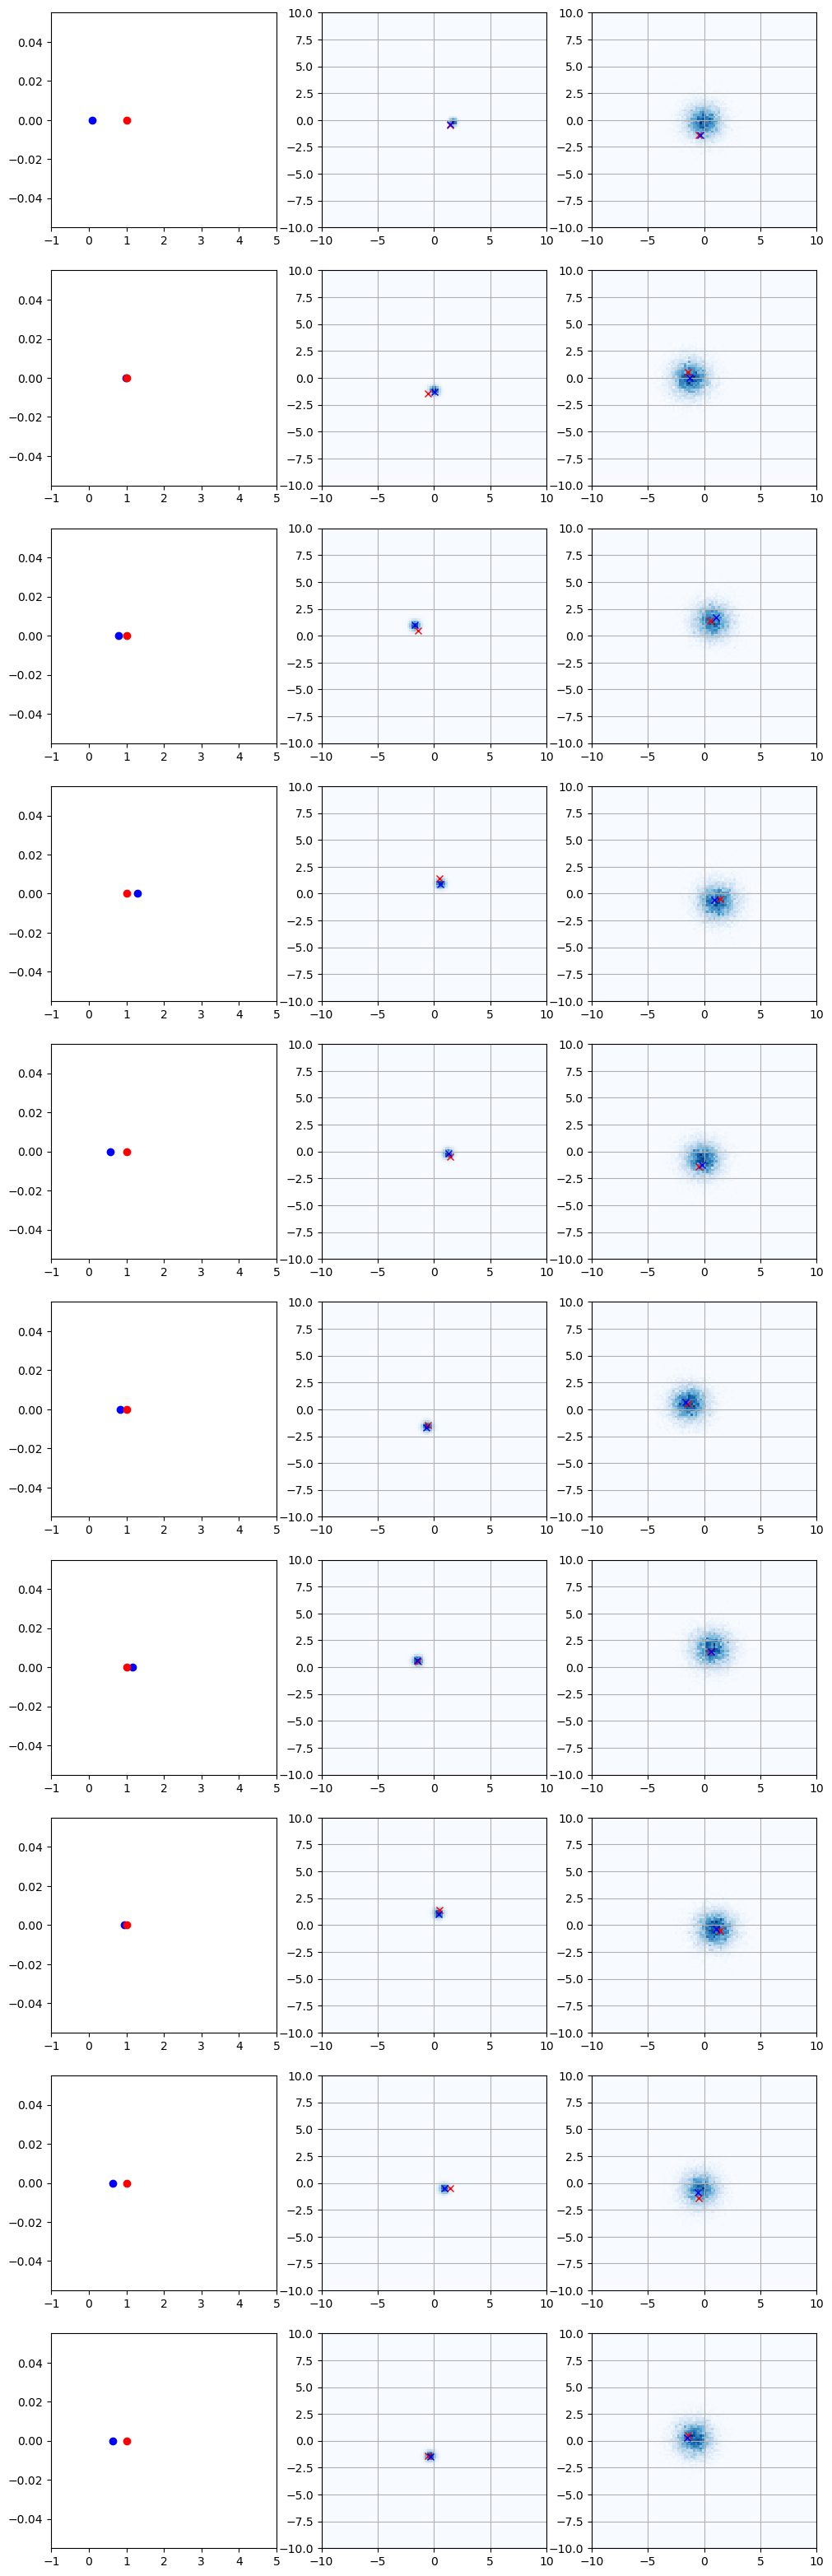

In [6]:
mu = np.array((2,0))
sigma = np.diag((1.,1.))/10
sigma_measure = np.diag((1.,1.))/10

thetaest = 0.1
thetatrue = 1.0
A = lambda theta: np.array([
    [0,theta],
    [-theta,0]
    ])

xtrue = np.random.multivariate_normal(mu, sigma)
xobs = observe(xtrue, sigma_measure)

r,c = 10,3
plt.figure(figsize=(c*4,r*4))

for iter in range(r):
    xobs = observe(xtrue, sigma_measure)

    plt.subplot(r,c,3*iter+1) 
    plt.plot(thetaest,0,"ob")
    plt.plot(thetatrue,0,"or")
    plt.xlim(-1,5)

    mu, sigma = update_distribution(mu, sigma, xobs, sigma_measure)

    plt.subplot(r,c,3*iter+2) 
    plotdistr(mu, sigma, xtrue, xobs)
    plt.grid()

    xtrue, xobs = A(thetatrue)@xtrue, A(thetatrue)@xobs
    mu, sigma = transform_distribution(mu, sigma, A(thetaest), bias=np.identity(2))

    plt.subplot(r,c,3*iter+3)
    plotdistr(mu, sigma, xtrue, xobs)
    plt.grid()

    thetaest = update_theta(thetaest, mu, sigma, xobs, sigma_measure, A)



In [6]:
class Noise():
    def __call__(self, *args):
        return 0

In [7]:
class SystemEnv():
    def __init__(self, system):
        self.system
    
    def reset(self):
        return
  
    def step(self, control):
        return state, reward, done

In [5]:
logger = SystemLogger()
system = CarSystem(start_position=0., start_velocity=10., slope_degr=10.)
times = np.arange(0,100)

for t in times:    
    logger.log(system)
    system.step(control=np.vstack([0]), dt=0.1)

velocity, position, _ = logger.state_trajectories
mass, friction, disturbance, motorgain = logger.parameters_trajectories


Text(0, 0.5, 'disturbance (N)')

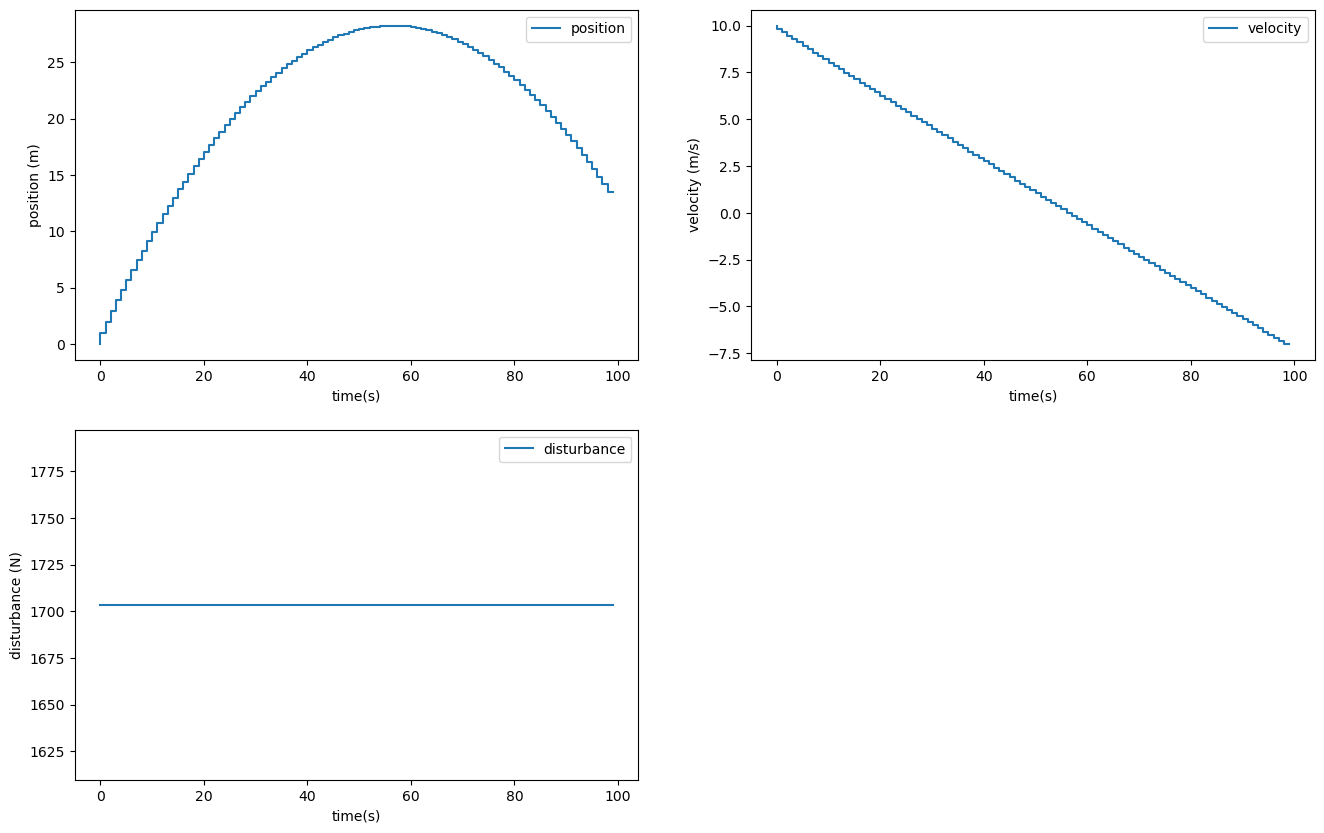

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.step(times, position, label="position")
plt.legend()
plt.xlabel("time(s)")
plt.ylabel("position (m)")

plt.subplot(222)
plt.step(times, velocity, label="velocity")
plt.legend()
plt.xlabel("time(s)")
plt.ylabel("velocity (m/s)")

plt.subplot(223)
plt.step(times, disturbance, label="disturbance")
plt.legend()
plt.xlabel("time(s)")
plt.ylabel("disturbance (N)")